In [27]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.models import Model, load_model
from tensorflow.python.client import device_lib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import LeakyReLU
from keras import backend as K 

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *

In [21]:
def plot_confusion_matrix(cm, class_names, title="Confusion matrix"):
    fig, ax  = plt.subplots(figsize=(4,4))
    heatmap = sn.heatmap(cm, annot=True,fmt='g', cmap='Blues', ax=ax,cbar=False)
    
    ax.set_title(title)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("True")
    
    heatmap.set_xticklabels(class_names)
    heatmap.set_yticklabels(class_names)

In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1282854217082654869
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7785862944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7482161426862867427
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'fine_tuning')
IMAGES_DIR = 'images' # 'D:\img32' # 'D:\\fall_images'

In [4]:
model = load_model(os.path.join('saved_models', 'transfer_learning', 'Coffee','cross_val_coffee_vietnam_1', 'cross_val_coffee_vietnam_1_4' + '.h5'), compile=False, custom_objects={'LeakyReLU':LeakyReLU})
model.trainable = True
model.training = False

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [6]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
np.random.shuffle(path1)
class1 = [0]*len(path1)

other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
np.random.shuffle(path2)
class2 = [1]*len(path2)

file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)
path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.20)

In [7]:
BATCH_SIZE = 64
LEARNING_RATE = 0.000001
DATA_AUGMENTATION_MULTIPLIATOR = 3
EPOCH = 150
RUN_NAME = 'finetuning_1'

In [8]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

In [9]:
train_generator = generator(path_train, 
                            y_train, 
                            vietnam_params['mean'], 
                            vietnam_params['std'], 
                            batch_size=BATCH_SIZE, 
                            is_data_augmentation=True)

test_generator = generator(path_test, 
                           y_test, 
                           vietnam_params['mean'], 
                           vietnam_params['std'], 
                           batch_size=BATCH_SIZE, 
                           is_data_augmentation=True)

In [10]:
earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)

In [11]:
history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper])

Epoch 1/150
147/147 [==============================] - 43s 193ms/step - loss: 1.9695 - accuracy: 0.5322 - val_loss: 0.6212 - val_accuracy: 0.7096
Epoch 2/150
147/147 [==============================] - 26s 180ms/step - loss: 1.8353 - accuracy: 0.5264 - val_loss: 1.0801 - val_accuracy: 0.6011
Epoch 3/150
147/147 [==============================] - 26s 180ms/step - loss: 1.4846 - accuracy: 0.5466 - val_loss: 3.7994 - val_accuracy: 0.5734
Epoch 4/150
147/147 [==============================] - 27s 181ms/step - loss: 1.4634 - accuracy: 0.5469 - val_loss: 3.7272 - val_accuracy: 0.5664
Epoch 5/150
147/147 [==============================] - 27s 182ms/step - loss: 1.3693 - accuracy: 0.5455 - val_loss: 3.3259 - val_accuracy: 0.5851
Epoch 6/150
147/147 [==============================] - 27s 181ms/step - loss: 1.2373 - accuracy: 0.5664 - val_loss: 2.8334 - val_accuracy: 0.5903
Epoch 7/150
147/147 [==============================] - 26s 179ms/step - loss: 1.1470 - accuracy: 0.5849 - val_loss: 5.7443 -

Epoch 57/150
147/147 [==============================] - 26s 178ms/step - loss: 0.6020 - accuracy: 0.7292 - val_loss: 0.8529 - val_accuracy: 0.7426
Epoch 58/150
147/147 [==============================] - 26s 180ms/step - loss: 0.5994 - accuracy: 0.7263 - val_loss: 0.9135 - val_accuracy: 0.7331
Epoch 59/150
147/147 [==============================] - 26s 179ms/step - loss: 0.5888 - accuracy: 0.7208 - val_loss: 0.8440 - val_accuracy: 0.7478
Epoch 60/150
147/147 [==============================] - 26s 180ms/step - loss: 0.6080 - accuracy: 0.7175 - val_loss: 0.6946 - val_accuracy: 0.7287
Epoch 61/150
147/147 [==============================] - 26s 180ms/step - loss: 0.6169 - accuracy: 0.7184 - val_loss: 0.6911 - val_accuracy: 0.7500
Epoch 62/150
147/147 [==============================] - 26s 178ms/step - loss: 0.6083 - accuracy: 0.7132 - val_loss: 0.7286 - val_accuracy: 0.7496
Epoch 63/150
147/147 [==============================] - 26s 177ms/step - loss: 0.6158 - accuracy: 0.7204 - val_loss: 0

In [12]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

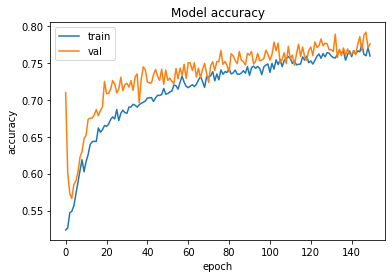

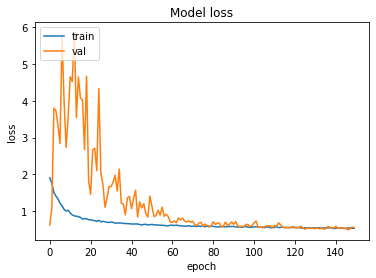

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
test_generator = generator(path_test, y_test, vietnam_params['mean'], vietnam_params['std'], batch_size=BATCH_SIZE)
model.evaluate(test_generator,steps=30)

30/30 [==============================] - 4s 134ms/step - loss: 0.5749 - accuracy: 0.7750


[0.5748904943466187, 0.7749999761581421]

In [20]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(np.where(model.predict(X) > 0.5, 1, 0))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       946
           1       0.84      0.66      0.74       974

    accuracy                           0.77      1920
   macro avg       0.78      0.77      0.77      1920
weighted avg       0.78      0.77      0.77      1920

F1-Score : 0.7436781609195402


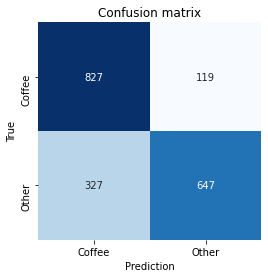

In [28]:
cm = confusion_matrix(Y_true, Y_pred)
plot_confusion_matrix(cm, ["Coffee", "Other"])
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")